In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import logging
import sys

import numpy as np
import pandas as pd
import sqlalchemy as sa

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

import pudl
from pudl.output.pudltabl import PudlTabl
from pudl.metadata.fields import apply_pudl_dtypes
from pudl.metadata.enums import STATE_TO_CENSUS_REGION

/home/zane/mambaforge/envs/pudl-dev/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter("%(message)s")
handler.setFormatter(formatter)
logger.handlers = [handler]

In [4]:
matplotlib.rcParams["figure.figsize"] = (10, 4)
matplotlib.rcParams["figure.dpi"] = 150
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [5]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])

# Read data from PUDL DB and create some features 

In [6]:
%%time
sql_select = """
    -- SQLite
    SELECT
        frc.plant_id_eia,
        frc.report_date,
        frc.contract_type_code,
        frc.contract_expiration_date,
        frc.energy_source_code,
        frc.supplier_name, -- Messy
        frc.fuel_received_units,
        frc.fuel_mmbtu_per_unit,
        frc.sulfur_content_pct,
        frc.ash_content_pct,
        frc.mercury_content_ppm,
        frc.moisture_content_pct,
        frc.chlorine_content_ppm,
        frc.fuel_cost_per_mmbtu,
        frc.primary_transportation_mode_code,
        frc.secondary_transportation_mode_code,
        frc.natural_gas_transport_code,
        frc.natural_gas_delivery_contract_type_code,

        mine.mine_name, -- Messy string
        mine.mine_type_code,
        mine.county_id_fips as mine_county_id_fips,
        mine.state as mine_state,
        mine.mine_id_msha,

        entity.iso_rto_code,
        entity.latitude,
        entity.longitude,
        entity.state,
        entity.county, -- Add county FIPS code
        entity.sector_name_eia,
        
        esc.fuel_group_eiaepm

    FROM fuel_receipts_costs_eia923 as frc
    LEFT JOIN coalmine_eia923 as mine
        USING (mine_id_pudl)
    LEFT JOIN plants_entity_eia as entity
        USING (plant_id_eia)
    LEFT JOIN energy_sources_eia as esc
           ON esc.code = frc.energy_source_code
    ;
"""
logger.info("Query data from the PUDL DB.")
frc_orig = (
    pd.read_sql(sql_select, pudl_engine)
    .pipe(apply_pudl_dtypes, group="eia")
    .pipe(pudl.helpers.add_fips_ids)
    .assign(
        # Remove 225 totally ridiculous outliers that skew the results
        fuel_cost_per_mmbtu=lambda x: np.where(((x.fuel_cost_per_mmbtu < 0.001) | (x.fuel_cost_per_mmbtu > 1000)), np.nan, x.fuel_cost_per_mmbtu),
        # Numerical representation of elapsed time
        elapsed_days=lambda x: (x.report_date - x.report_date.min()).dt.days,
        # Time until current contract expires
        remaining_contract_days=lambda x: (x.contract_expiration_date - x.report_date).dt.days,
        # Categorical months, to capture cyclical seasonal variability
        report_month=lambda x: x.report_date.dt.month,
        # Larger geographic area more likely to have lots of records
        census_region=lambda x: x.state.map(STATE_TO_CENSUS_REGION),
        # Need the total MMBTU for weighting the importance of the record
        # May also be predictive -- small deliveries seem more likely to be expensive
        fuel_received_mmbtu=lambda x: x.fuel_received_units * x.fuel_mmbtu_per_unit,
        mine_plant_same_state=lambda x: (x.state == x.mine_state).fillna(False),
        mine_plant_same_county=lambda x: (x.county_id_fips == x.mine_county_id_fips).fillna(False),
    )
    .convert_dtypes(convert_floating=False, convert_integer=False)
    .astype({
        "mine_id_msha": float,
        "plant_id_eia": int,
    })
)
# The HistGBR model and OrdinalEncoder are supposedly fine with NA values but...
string_cols = frc_orig.select_dtypes("string").columns
frc_orig.loc[:, string_cols] = frc_orig[string_cols].fillna("NULL")

# There are too many FIPS codes to treat them like categories
bad_categories = ["county_id_fips", "mine_county_id_fips"]
category_cols = {col: "category" for col in string_cols if col not in bad_categories}

frc_orig = frc_orig.astype(category_cols)

# Preserve the original so we can compare later
frc = frc_orig.copy()

frc.info()

Query data from the PUDL DB.
Assigned state FIPS codes for 98.16% of records.
Assigned county FIPS codes for 94.75% of records.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571400 entries, 0 to 571399
Data columns (total 39 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   plant_id_eia                             571400 non-null  int64         
 1   report_date                              571400 non-null  datetime64[ns]
 2   contract_type_code                       571400 non-null  category      
 3   contract_expiration_date                 248824 non-null  datetime64[ns]
 4   energy_source_code                       571400 non-null  category      
 5   supplier_name                            571400 non-null  category      
 6   fuel_received_units                      571400 non-null  float64       
 7   fuel_mmbtu_per_unit                      571400 non-nu

# Select features to use

In [7]:
feature_cols = [
# Categorical
    "energy_source_code",
#    "contract_type_code",
#    "primary_transportation_mode_code",
#    "natural_gas_delivery_contract_type_code",
#    "natural_gas_transport_code",
#    "mine_type_code",
#   "mine_state",
#    "iso_rto_code",
#   "sector_name_eia",
#   "county_id_fips",
#   "mine_plant_same_state",  # bool
#   "mine_plant_same_county", # bool
    "state",
#   "census_region",
#   "secondary_transportation_mode_code",
#   "mine_county_id_fips",
#   "fuel_group_eiaepm",
    
# Numerical
#   "mine_id_msha",
#   "latitude",
#   "longitude",
#   "sulfur_content_pct",
#   "ash_content_pct",
#   "moisture_content_pct",
#   "mercury_content_ppm",
#   "chlorine_content_ppm",
#   "remaining_contract_days",
#   "plant_id_eia", 
    "report_month",
    "elapsed_days",
#   "fuel_received_mmbtu",
#   "fuel_cost_per_mmbtu",
#   "fuel_mmbtu_per_unit",
#   "fuel_received_units",
]

# Records where we have the target value:
frc_train = frc.loc[frc.fuel_cost_per_mmbtu.notna(), feature_cols]

# Relative importance of each of the records:
sample_weight = frc.loc[frc.fuel_cost_per_mmbtu.notna(), "fuel_received_mmbtu"]

# The values we're trying to predict:
frc_target = frc.loc[frc.fuel_cost_per_mmbtu.notna(), "fuel_cost_per_mmbtu"]

# Records where we're missing the target value:
frc_to_predict = frc.loc[frc.fuel_cost_per_mmbtu.isna(), feature_cols]

In [8]:
frc_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381214 entries, 0 to 571399
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   energy_source_code  381214 non-null  category
 1   state               381214 non-null  category
 2   report_month        381214 non-null  int64   
 3   elapsed_days        381214 non-null  int64   
dtypes: category(2), int64(2)
memory usage: 9.5 MB


# Build a Pipeline

In [9]:
# Identify which columns should be treated as categorical features:
cat_cols_idx = frc_train.columns.get_indexer(frc_train.select_dtypes("category").columns)

ord_enc = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        make_column_selector(dtype_include=["category", "string"]),
    ),
    remainder="passthrough",
)

fuel_price_estimator = Pipeline([
    ("ord_enc", ord_enc),
    ("hist_gbr", HistGradientBoostingRegressor(loss="absolute_error", categorical_features=cat_cols_idx, random_state=666)),
    #("hist_gbr", HistGradientBoostingRegressor(loss="quantile", quantile=0.5, categorical_features=cat_cols_idx, random_state=666)),
])

# Grid Search Cross Validation

{'hist_gbr__learning_rate': 0.1,
 'hist_gbr__max_depth': 7,
 'hist_gbr__max_iter': 1000,
 'hist_gbr__max_leaf_nodes': 31,
 'hist_gbr__min_samples_leaf': 20}

-0.5895969415070624

CPU times: user 1min 23s, sys: 623 ms, total: 1min 23s
Wall time: 2min 9s


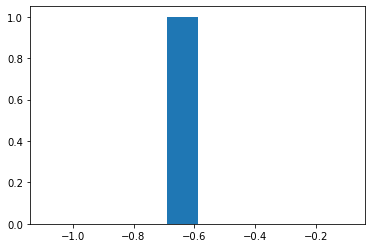

In [10]:
%%time

# Split based on Plant ID to avoid plant information leaking between test / training
gss = GroupShuffleSplit(n_splits=5, random_state=666)
gss_split = gss.split(frc_train, groups=frc_train["state"])
# This grid took 4h21m to run
param_grid = {
#    "hist_gbr__max_depth": [3, 5, 7],
#    "hist_gbr__max_leaf_nodes": [7, 15, 31],
#    "hist_gbr__learning_rate": [0.05, 0.1, 0.2, 0.4],
#    "hist_gbr__max_iter": [100, 1000],
#    "hist_gbr__min_samples_leaf": [25, 50, 100],
    "hist_gbr__learning_rate": [0.1],
    "hist_gbr__max_depth": [7],
    "hist_gbr__max_leaf_nodes": [31],
    "hist_gbr__max_iter": [1000],
    "hist_gbr__min_samples_leaf": [20],
}

# Define hyperparameter space to search:
grid = GridSearchCV(
    fuel_price_estimator,
    param_grid=param_grid,
    cv=gss_split,
    scoring='neg_median_absolute_error',
    n_jobs=-1,
)

# Train up all the models and store the results.
# Weight samples by `sample_weight` during training.
result = grid.fit(
    X=frc_train,
    y=frc_target,
    hist_gbr__sample_weight=sample_weight,
)
plt.hist(result.cv_results_["mean_test_score"]);

# Best estimator from the GridSearchCV
fuel_price_estimator = grid.best_estimator_

display(result.best_params_)
# {'hist_gbr__learning_rate': 0.1,
# 'hist_gbr__max_depth': 7,
# 'hist_gbr__max_iter': 1000,
# 'hist_gbr__max_leaf_nodes': 31,
# 'hist_gbr__min_samples_leaf': 25}
display(result.best_score_)
# -0.48774031431806203

# Train estimate and predict ALL fuel pirces

In [11]:
%%time

# After selecting the best hyperparameters from the GridSearchCV,
# Retrain the model using all of the available training data
_ = fuel_price_estimator.fit(
    X=frc_train,
    y=frc_target,
   hist_gbr__sample_weight=sample_weight,
)

# Use it to predict ALL fuel prices
fuel_cost_per_mmbtu_predicted = fuel_price_estimator.predict(X=pd.concat([frc_to_predict, frc_train]))

# Re-assemble the original data with our new predictions
frc_predicted = (
    frc.copy()
    .assign(
        fuel_cost_per_mmbtu=frc_target,
        fuel_cost_per_mmbtu_predicted=fuel_cost_per_mmbtu_predicted,
        fuel_cost_total=lambda x: x.fuel_cost_per_mmbtu * x.fuel_received_mmbtu,
        fuel_cost_total_predicted=lambda x: x.fuel_cost_per_mmbtu_predicted * x.fuel_received_mmbtu,
    )
)

CPU times: user 2min 6s, sys: 627 ms, total: 2min 6s
Wall time: 50.4 s


In [12]:
assert False

AssertionError: 

# Visualize fuel price predictions
* Time series by (fuel, state):
  * Predicted vs Reported for test/train
  * Time series where gaps are filled, highlighting original / filled values
* Distribution of Predicted vs. Reported values for test/train data

## Fuel price histograms

In [ ]:
def compare_price_distribution(df, fuel_col, weights, fuel_code=None, state=None, **kwargs):
    if fuel_code:
        df = df[df[fuel_col]==fuel_code]
    if state:
        df = df[df.state==state]
    if df.empty:
        return

    plt.hist(
        df.fuel_cost_per_mmbtu,
        weights=df[weights],
        label="Reported",
        alpha=0.5,
        **kwargs
    )
    plt.hist(
        df[df.fuel_cost_per_mmbtu.notna()]["fuel_cost_per_mmbtu_predicted"],
        weights=df[df.fuel_cost_per_mmbtu.notna()][weights],
        label="Predicted",
        alpha=0.5,
        **kwargs
    )
    plt.xlabel("Fuel Price [$/MMBTU]")
    plt.title(f"{state} {fuel_col}: {fuel_code}")
    plt.legend()
    plt.show();

In [ ]:
matplotlib.rcParams["figure.figsize"] = (10, 4)
matplotlib.rcParams["figure.dpi"] = 150

states = sorted(frc_predicted.state.unique())
states = sorted(["AL", "NY", "CA", "CO", "FL", "TX"])

for state in sorted(frc_predicted.state.unique()):
    for fuel_code in ["coal", "natural_gas", "petroleum"]:
        compare_price_distribution(
            df=frc_predicted,
            fuel_col="fuel_group_eiaepm",
            weights="fuel_received_mmbtu",
            fuel_code=fuel_code,
            state=state,
            bins=100,
            range=(0,25),
        )

## Joint Price Distributions by Fuel

In [ ]:
def fuel_price_joint_grid(df, fuel_col=None, fuel_code=None, xlim=None, cmap="viridis"):
    if fuel_col and fuel_code:
        df = df.loc[df[fuel_col] == fuel_code]
    if df["fuel_cost_per_mmbtu_predicted"].empty or df["fuel_cost_per_mmbtu"].empty:
        return
    if not xlim:
        predicted_95 = df["fuel_cost_per_mmbtu_predicted"].quantile(0.95)
        reported_95 = df["fuel_cost_per_mmbtu"].quantile(0.95)
        xlim = (0, max(predicted_95, reported_95))
    g = sns.JointGrid(
        data=df,
        x="fuel_cost_per_mmbtu",
        y="fuel_cost_per_mmbtu_predicted",
        xlim=xlim,
        ylim=xlim,
        dropna=True,
    )
    g.plot_joint(
        sns.kdeplot,
        weights=df["fuel_received_mmbtu"],
        cmap=cmap,
        fill=True,
        clip=(xlim, xlim),
        levels=100,
        gridsize=100,
        thresh=0,
    )
    g.plot_marginals(
        sns.histplot,
        weights=df["fuel_received_mmbtu"],
        binrange=xlim,
        stat="density",
        bins=100,
        linewidth=0,
        color=matplotlib.cm.get_cmap(cmap)(0.1),
        alpha=1.0,
    )
    g.set_axis_labels(
        "Reported [$/MMBTU]",
        "Predicted [$/MMBTU]",
    )
    plt.suptitle(f"{fuel_col}: {fuel_code}", x=0.75)
    plt.show();
    
def all_fuel_price_joint_grids(df, fuel_col, xlim=None, cmap="viridis"):
    for fuel_code in df[fuel_col].unique():
        logger.info(f"Plotting: {fuel_col}={fuel_code}")
        if fuel_code == "NULL":
            continue
        try:
            fuel_price_joint_grid(df, fuel_col=fuel_col, fuel_code=fuel_code, cmap=cmap)
        except:
            continue

In [ ]:
%%time
all_fuel_price_joint_grids(frc_predicted, "energy_source_code")
#all_fuel_price_joint_grids(frc_predicted, "fuel_group_eiaepm")

In [ ]:
assert False

## Time Series by State & Fuel

In [ ]:
%%time
frc_predicted_state_fuel = (
    frc_predicted.groupby(["state", "fuel_group_eiaepm", "report_date"], observed=True)[[
        "fuel_cost_total_predicted",
        "fuel_cost_total",
        "fuel_received_mmbtu",
    ]].sum(min_count=1)
    .assign(
        fuel_cost_per_mmbtu=lambda x: x.fuel_cost_total / x.fuel_received_mmbtu,
        fuel_cost_per_mmbtu_predicted=lambda x: x.fuel_cost_total_predicted / x.fuel_received_mmbtu,
    )
    .drop(columns=["fuel_cost_total_predicted", "fuel_cost_total", "fuel_received_mmbtu"])
    .rename(columns={
        "fuel_cost_per_mmbtu": "reported",
        "fuel_cost_per_mmbtu_predicted": "predicted",
    })
    .stack(dropna=False)
    .to_frame().reset_index()
    .astype({
        "state": "string",
        "fuel_group_eiaepm": "string",
    })
    .query("state!='NULL' & fuel_group_eiaepm!='NULL'")
    .rename(columns={
        "level_3": "source",
        0: "fuel_price",
        "fuel_group_eiaepm": "fuel_group",
    })
)

frc_predicted_state_fuel

In [ ]:
states = ["NY", "FL", "CA", "TX"]
fuels = ["coal", "natural_gas"]
df = frc_predicted_state_fuel[
    # (frc_predicted_state_fuel.state.isin(states))
    (frc_predicted_state_fuel.fuel_group.isin(fuels))
]
sns.relplot(
    data=df,
    x="report_date",
    y="fuel_price",
    hue="source",
    style="source",
    kind="line",
    row="state",
    col="fuel_group",
    height=3,
    aspect=3,
)

In [ ]:
mfcs = {
    "energy_source_code": ["BIT", "SUB", "LIG", "NG", "DFO", "RFO"],
    "fuel_group_eiaepm": ["coal", "petroleum", "natural_gas"],
}
mfc = "energy_source_code"
# mfc = "fuel_group_eiaepm"
mfcs[mfc]

In [ ]:
logger.info("Predicted Fuel Prices")
sns.displot(
    data=frc_predicted[frc_predicted[mfc].isin(mfcs[mfc])],
    x="fuel_cost_per_mmbtu",
    row=mfc,
    bins=400,
    weights=frc_predicted[frc_predicted[mfc].isin(mfcs[mfc])]["fuel_received_mmbtu"],
    binrange=(0,40),
    height=2,
    aspect=4,
    linewidth=0,
    stat="density",
    common_norm=False,
)
plt.show();

logger.info("Observed Fuel Prices")
sns.displot(
    data=frc_train_test[frc_train_test[mfc].isin(mfcs[mfc])],
    x="fuel_cost_per_mmbtu",
    row=mfc,
    bins=400,
    weights=frc_train_test[frc_train_test[mfc].isin(mfcs[mfc])]["fuel_received_mmbtu"],
    binrange=(0,40),
    height=2,
    aspect=4,
    linewidth=0,
    stat="density",
    common_norm=False,
)
plt.show();